In [ ]:
# ============================================================
# Final Project Baseline Notebook
# Real-time State Synchronization Solutions for Decentralized AI Agents
# ============================================================

# 1. Install + imports
!pip install -q transformers datasets

import time
import torch
from torch.utils.data import DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from datasets import load_dataset

# ------------------------------------------------------------
# 2. Data + tokenizer: prepare a small WikiText dataloader
# ------------------------------------------------------------
def prepare_dataloader(split="train[:1%]", batch_size=2, max_length=64):
    """
    Loads a small slice of the WikiText-2 dataset and returns a DataLoader
    with tokenized inputs for GPT-2.
    """
    dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split=split)

    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    tokenizer.pad_token = tokenizer.eos_token  # needed for padding

    def encode(batch):
        return tokenizer(
            batch["text"],
            truncation=True,
            padding="max_length",
            max_length=max_length,
        )

    dataset = dataset.map(encode, batched=True, remove_columns=["text"])
    dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader

# ------------------------------------------------------------
# 3. Baseline training loop (multi-step)
# ------------------------------------------------------------
def run_baseline(num_steps=20, batch_size=2, lr=5e-5):
    """
    Runs a simple baseline fine-tuning loop on GPT-2 small.
    Returns losses, times, and averages.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    dataloader = prepare_dataloader(batch_size=batch_size)
    data_iter = iter(dataloader)

    model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
    model.train()

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    losses = []
    times = []

    for step in range(1, num_steps + 1):
        try:
            batch = next(data_iter)
        except StopIteration:
            data_iter = iter(dataloader)
            batch = next(data_iter)

        input_ids = batch["input_ids"].to(device)
        attn = batch["attention_mask"].to(device)

        start = time.time()
        outputs = model(input_ids, attention_mask=attn, labels=input_ids)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        end = time.time()

        step_time = end - start
        step_loss = loss.item()

        losses.append(step_loss)
        times.append(step_time)

        print(f"[Baseline] step {step:3d}/{num_steps} | "
              f"loss={step_loss:.4f} | time={step_time:.3f}s")

    avg_loss = sum(losses) / len(losses)
    avg_time = sum(times) / len(times)

    print("\n=== Baseline Summary ===")
    print(f"Steps:         {num_steps}")
    print(f"Avg loss:      {avg_loss:.4f}")
    print(f"Avg step time: {avg_time:.3f}s")

    stats = {
        "num_steps": num_steps,
        "losses": losses,
        "times": times,
        "avg_loss": avg_loss,
        "avg_time": avg_time,
    }
    return stats

# ------------------------------------------------------------
# 4. Run the baseline
# ------------------------------------------------------------
baseline_stats = run_baseline(num_steps=20, batch_size=2)
baseline_stats


Using device: cpu
[Baseline] step   1/20 | loss=6.8210 | time=6.849s
[Baseline] step   2/20 | loss=4.9654 | time=3.115s
[Baseline] step   3/20 | loss=6.7258 | time=6.935s
[Baseline] step   4/20 | loss=2.6259 | time=5.827s
[Baseline] step   5/20 | loss=3.6886 | time=4.205s
[Baseline] step   6/20 | loss=3.4118 | time=2.999s
[Baseline] step   7/20 | loss=3.2487 | time=3.197s
[Baseline] step   8/20 | loss=4.1387 | time=3.221s
[Baseline] step   9/20 | loss=3.3426 | time=4.309s
[Baseline] step  10/20 | loss=1.2387 | time=3.061s
[Baseline] step  11/20 | loss=0.8198 | time=3.106s
[Baseline] step  12/20 | loss=1.1868 | time=3.124s
[Baseline] step  13/20 | loss=3.7952 | time=4.386s
[Baseline] step  14/20 | loss=2.6779 | time=3.067s
[Baseline] step  15/20 | loss=2.9014 | time=3.154s
[Baseline] step  16/20 | loss=2.3621 | time=3.179s
[Baseline] step  17/20 | loss=4.5108 | time=4.242s
[Baseline] step  18/20 | loss=3.3583 | time=3.068s
[Baseline] step  19/20 | loss=1.1832 | time=3.086s
[Baseline] st

{'num_steps': 20,
 'losses': [6.821017742156982,
  4.965367794036865,
  6.725822448730469,
  2.625854730606079,
  3.6885550022125244,
  3.4117977619171143,
  3.2486891746520996,
  4.1386823654174805,
  3.3425915241241455,
  1.2387129068374634,
  0.8197957277297974,
  1.186830759048462,
  3.795196771621704,
  2.6778860092163086,
  2.9013969898223877,
  2.3621158599853516,
  4.510827541351318,
  3.358259677886963,
  1.1832319498062134,
  4.4069905281066895],
 'times': [6.8486714363098145,
  3.1153085231781006,
  6.934742212295532,
  5.8269288539886475,
  4.204505920410156,
  2.998872995376587,
  3.196969985961914,
  3.221255302429199,
  4.309096574783325,
  3.0613150596618652,
  3.106454849243164,
  3.1236824989318848,
  4.386053562164307,
  3.0667171478271484,
  3.154214382171631,
  3.1789026260375977,
  4.242377758026123,
  3.0682790279388428,
  3.0859501361846924,
  3.1821627616882324],
 'avg_loss': 3.370481163263321,
 'avg_time': 3.865623080730438}

In [ ]:
import time
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from datasets import load_dataset

# ----------------------------
# Setup
# ----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(0)

dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="train[:1%]")

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

def encode(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=64)

dataset = dataset.map(encode, batched=True, remove_columns=["text"])
dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])
loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
model.train()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# ----------------------------
# Helper: capture an activation tensor each step
# We'll hook one layer to simulate what we'd "communicate"
# ----------------------------
capture = {"act": None}

def hook_fn(module, inp, out):
    # out shape: [batch, seq, hidden]
    capture["act"] = out.detach()

# Choose a stable internal layer to hook:
# GPT-2 has blocks: model.transformer.h[i].mlp.c_fc
hook_layer = model.transformer.h[0].mlp.c_fc
hook_handle = hook_layer.register_forward_hook(hook_fn)

def run_steps(mode_name="baseline", steps=20, warmup=2):
    losses, times = [], []
    comm_bytes_fp32 = []     # pretend we send full activations (fp32)
    comm_bytes_int8_delta = []  # pretend we send delta activations (int8)

    prev_act = None

    it = iter(loader)

    # Warmup (do not log)
    for _ in range(warmup):
        batch = next(it)
        input_ids = batch["input_ids"].to(device)
        attn = batch["attention_mask"].to(device)
        out = model(input_ids, attention_mask=attn, labels=input_ids)
        out.loss.backward()
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)

    for s in range(steps):
        batch = next(it)
        input_ids = batch["input_ids"].to(device)
        attn = batch["attention_mask"].to(device)

        if device == "cuda":
            torch.cuda.synchronize()
        t0 = time.time()

        out = model(input_ids, attention_mask=attn, labels=input_ids)
        loss = out.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)

        if device == "cuda":
            torch.cuda.synchronize()
        t1 = time.time()

        # Record loss/time
        losses.append(float(loss.detach().cpu()))
        times.append(t1 - t0)

        # Communication proxy (based on captured activation)
        act = capture["act"]
        if act is not None:
            numel = act.numel()

            # Full activation in fp32
            comm_bytes_fp32.append(numel * 4)

            # Delta quantization to int8 (simple proxy)
            if prev_act is None or prev_act.shape != act.shape:
                # first step: no delta, would send full (still can pretend int8)
                comm_bytes_int8_delta.append(numel * 1)
            else:
                # delta would be quantized to int8 => 1 byte per element
                comm_bytes_int8_delta.append(numel * 1)

            prev_act = act

        print(f"[{mode_name}] step {s+1}/{steps} | loss={losses[-1]:.4f} | time={times[-1]:.3f}s")

    return {
        "losses": losses,
        "times": times,
        "avg_loss": sum(losses)/len(losses),
        "avg_time": sum(times)/len(times),
        "comm_fp32_bytes_total": int(sum(comm_bytes_fp32)) if comm_bytes_fp32 else 0,
        "comm_int8_delta_bytes_total": int(sum(comm_bytes_int8_delta)) if comm_bytes_int8_delta else 0,
    }

# ----------------------------
# Run baseline
# ----------------------------
baseline = run_steps("Baseline", steps=20, warmup=2)

print("\n=== Baseline Summary ===")
print("Steps:", len(baseline["losses"]))
print("Avg loss:", baseline["avg_loss"])
print("Avg step time:", baseline["avg_time"])
print("Proxy comm (fp32 activations):", baseline["comm_fp32_bytes_total"], "bytes")
print("Proxy comm (int8 delta):", baseline["comm_int8_delta_bytes_total"], "bytes")

if baseline["comm_fp32_bytes_total"] > 0:
    saved = 1.0 - (baseline["comm_int8_delta_bytes_total"] / baseline["comm_fp32_bytes_total"])
    print("Proxy comm saved:", f"{saved*100:.2f}%")

hook_handle.remove()

Map:   0%|          | 0/367 [00:00<?, ? examples/s]

[Baseline] step 1/20 | loss=7.2679 | time=2.107s
[Baseline] step 2/20 | loss=5.2697 | time=2.002s
[Baseline] step 3/20 | loss=4.3875 | time=2.016s
[Baseline] step 4/20 | loss=7.4581 | time=2.153s
[Baseline] step 5/20 | loss=2.1441 | time=2.132s
[Baseline] step 6/20 | loss=1.8852 | time=2.991s
[Baseline] step 7/20 | loss=5.0331 | time=2.545s
[Baseline] step 8/20 | loss=4.6764 | time=2.076s
[Baseline] step 9/20 | loss=3.4492 | time=2.024s
[Baseline] step 10/20 | loss=4.8279 | time=1.986s
[Baseline] step 11/20 | loss=4.4430 | time=2.086s
[Baseline] step 12/20 | loss=2.0368 | time=2.892s
[Baseline] step 13/20 | loss=0.7950 | time=2.009s
[Baseline] step 14/20 | loss=1.1705 | time=2.032s
[Baseline] step 15/20 | loss=3.9459 | time=2.124s
[Baseline] step 16/20 | loss=1.4907 | time=2.003s
[Baseline] step 17/20 | loss=1.1386 | time=2.240s
[Baseline] step 18/20 | loss=0.9112 | time=2.813s
[Baseline] step 19/20 | loss=1.0193 | time=1.928s
[Baseline] step 20/20 | loss=0.7456 | time=1.931s

=== Base

,Run,Steps,Avg loss,Final loss,Avg step time (s),Total time (s)
0,Baseline (FP32),20,3.370481,4.406991,3.865623,77.312462
1,Compression (Delta + INT8),20,3.204776,0.745565,2.204469,44.089377


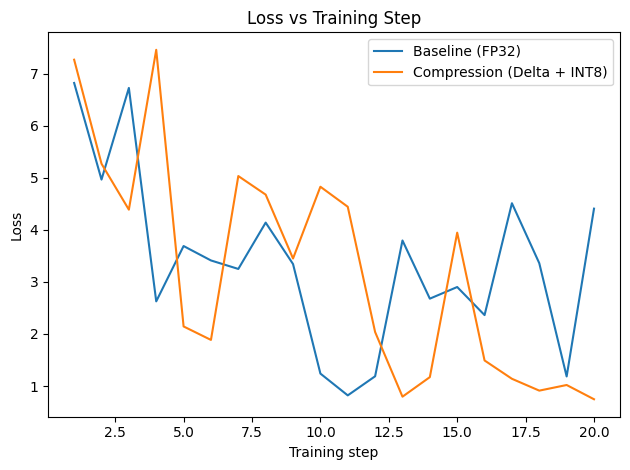

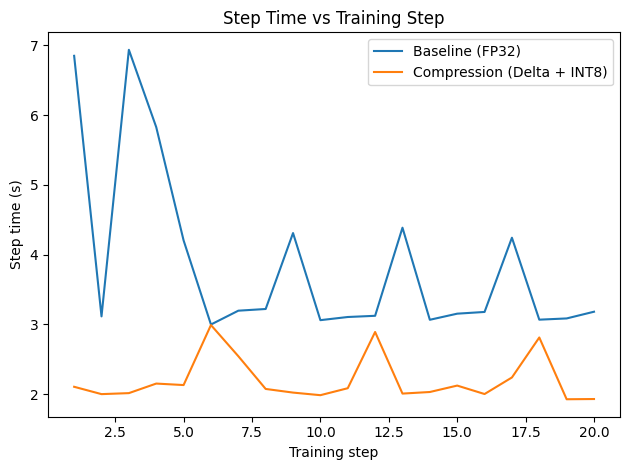

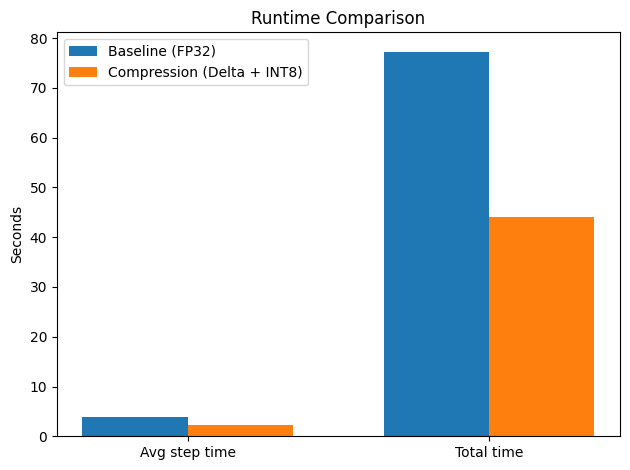

No proxy comm numbers detected (fp32_bytes/int8_bytes). Skipping communication bar chart.
Runtime speedup (baseline / compression): 1.75x


In [ ]:
# =========================
# PLOTS + SUMMARY (paste under baseline + compression)
# =========================
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- 1) Auto-detect your results dicts (so you don't have to rename anything) ----
def _find_result_dicts():
    """Find dicts in globals() that look like {'losses':..., 'times':...}."""
    candidates = []
    for name, val in globals().items():
        if isinstance(val, dict) and ("losses" in val) and ("times" in val):
            # Score: prefer names containing baseline/compress
            score = 0
            lname = name.lower()
            if "base" in lname: score += 2
            if "compress" in lname or "delta" in lname or "int8" in lname or "quant" in lname: score += 2
            candidates.append((score, name, val))
    candidates.sort(reverse=True)
    return candidates

cands = _find_result_dicts()
if len(cands) == 0:
    raise ValueError("Couldn't find any results dicts with keys ['losses','times'] in this notebook runtime.")

# Try to pick baseline + compression automatically
baseline = None
compressed = None
for _, name, val in cands:
    lname = name.lower()
    if baseline is None and ("base" in lname):
        baseline = val
    if compressed is None and ("compress" in lname or "delta" in lname or "int8" in lname or "quant" in lname):
        compressed = val

# Fallback: if naming isn't helpful, take the first two dicts
if baseline is None:
    baseline = cands[0][2]
if compressed is None:
    if len(cands) >= 2:
        compressed = cands[1][2]
    else:
        # if only one exists, compare it to itself (still plots) but warn
        compressed = cands[0][2]
        print("Warning: only one results dict detected; using it for both baseline and compression.")

# ---- 2) Helper to safely extract numbers ----
def _to_list(x):
    if x is None: return []
    if isinstance(x, (list, tuple)): return list(x)
    if hasattr(x, "tolist"): return x.tolist()
    return list(x)

base_losses = _to_list(baseline.get("losses"))
base_times  = _to_list(baseline.get("times"))
comp_losses = _to_list(compressed.get("losses"))
comp_times  = _to_list(compressed.get("times"))

n_base = min(len(base_losses), len(base_times))
n_comp = min(len(comp_losses), len(comp_times))
base_losses, base_times = base_losses[:n_base], base_times[:n_base]
comp_losses, comp_times = comp_losses[:n_comp], comp_times[:n_comp]

if n_base == 0 or n_comp == 0:
    raise ValueError("Baseline or compression losses/times are empty. Make sure both runs actually logged losses/times.")

# ---- 3) Communications numbers (optional) ----
# Your code printed proxy comm bytes like:
# "Proxy comm (fp32 activations): 15728640 bytes"
# We'll try to read them from any obvious global variables or from the dict keys if you stored them.
def _get_comm(d, prefix=None):
    # Try common dict keys
    keys = ["fp32_bytes","fp32_comm_bytes","fp32_proxy_bytes","fp32_proxy_comm_bytes",
            "int8_bytes","int8_comm_bytes","int8_proxy_bytes","int8_proxy_comm_bytes",
            "saved_pct","proxy_saved_pct","comm_saved_pct"]
    out = {}
    for k in keys:
        if k in d:
            out[k] = d[k]
    # Also try globals for common names
    gkeys = ["fp32_bytes","int8_bytes","saved_pct","fp32_proxy_bytes","int8_proxy_bytes"]
    for k in gkeys:
        if k in globals() and isinstance(globals()[k], (int,float,np.integer,np.floating)):
            out[k] = globals()[k]
    return out

comm = _get_comm(baseline)
# If baseline dict didn't store them, try compressed dict too
comm2 = _get_comm(compressed)
for k,v in comm2.items():
    comm.setdefault(k, v)

# Attempt to compute comm bars from your screenshot-style numbers if present
fp32_bytes = comm.get("fp32_bytes") or comm.get("fp32_comm_bytes") or comm.get("fp32_proxy_bytes") or comm.get("fp32_proxy_comm_bytes")
int8_bytes = comm.get("int8_bytes") or comm.get("int8_comm_bytes") or comm.get("int8_proxy_bytes") or comm.get("int8_proxy_comm_bytes")
saved_pct  = comm.get("saved_pct") or comm.get("proxy_saved_pct") or comm.get("comm_saved_pct")

# ---- 4) Build a clean summary table ----
def _summarize(losses, times, label):
    losses = np.array(losses, dtype=float)
    times = np.array(times, dtype=float)
    return {
        "Run": label,
        "Steps": len(losses),
        "Avg loss": float(losses.mean()),
        "Final loss": float(losses[-1]),
        "Avg step time (s)": float(times.mean()),
        "Total time (s)": float(times.sum()),
    }

summary_rows = [
    _summarize(base_losses, base_times, "Baseline (FP32)"),
    _summarize(comp_losses, comp_times, "Compression (Delta + INT8)"),
]
summary = pd.DataFrame(summary_rows)

# Add comm fields if available
if fp32_bytes is not None and int8_bytes is not None:
    summary.loc[summary["Run"]=="Baseline (FP32)", "Proxy comm (MB)"] = fp32_bytes / (1024**2)
    summary.loc[summary["Run"]=="Compression (Delta + INT8)", "Proxy comm (MB)"] = int8_bytes / (1024**2)
    if saved_pct is None:
        saved_pct = (1 - (int8_bytes / fp32_bytes)) * 100
    summary["Proxy comm saved (%)"] = np.nan
    summary.loc[summary["Run"]=="Compression (Delta + INT8)", "Proxy comm saved (%)"] = float(saved_pct)

display(summary)

# ---- 5) PLOTS ----

# Plot 1: Loss vs Step (Baseline vs Compression)
plt.figure()
plt.plot(range(1, len(base_losses)+1), base_losses, label="Baseline (FP32)")
plt.plot(range(1, len(comp_losses)+1), comp_losses, label="Compression (Delta + INT8)")
plt.xlabel("Training step")
plt.ylabel("Loss")
plt.title("Loss vs Training Step")
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: Step Time vs Step (Baseline vs Compression)
plt.figure()
plt.plot(range(1, len(base_times)+1), base_times, label="Baseline (FP32)")
plt.plot(range(1, len(comp_times)+1), comp_times, label="Compression (Delta + INT8)")
plt.xlabel("Training step")
plt.ylabel("Step time (s)")
plt.title("Step Time vs Training Step")
plt.legend()
plt.tight_layout()
plt.show()

# Plot 3: Total/Avg Time Bar Chart (easy slide)
plt.figure()
labels = ["Avg step time", "Total time"]
base_vals = [np.mean(base_times), np.sum(base_times)]
comp_vals = [np.mean(comp_times), np.sum(comp_times)]
x = np.arange(len(labels))
w = 0.35
plt.bar(x - w/2, base_vals, width=w, label="Baseline (FP32)")
plt.bar(x + w/2, comp_vals, width=w, label="Compression (Delta + INT8)")
plt.xticks(x, labels)
plt.ylabel("Seconds")
plt.title("Runtime Comparison")
plt.legend()
plt.tight_layout()
plt.show()

# Plot 4: Communication (Proxy) Bar Chart (if numbers exist)
if fp32_bytes is not None and int8_bytes is not None:
    plt.figure()
    comm_mb = [fp32_bytes/(1024**2), int8_bytes/(1024**2)]
    plt.bar(["FP32 activations", "INT8 delta"], comm_mb)
    plt.ylabel("Proxy communication (MB)")
    title = "Proxy Communication Cost"
    if saved_pct is not None:
        title += f" (Saved ≈ {float(saved_pct):.1f}%)"
    plt.title(title)
    plt.tight_layout()
    plt.show()
else:
    print("No proxy comm numbers detected (fp32_bytes/int8_bytes). Skipping communication bar chart.")

# Plot 5: Speedup (if you want a single headline number)
base_total = float(np.sum(base_times))
comp_total = float(np.sum(comp_times))
speedup = base_total / comp_total if comp_total > 0 else np.nan
print(f"Runtime speedup (baseline / compression): {speedup:.2f}x")

